# Artificial Neural Networks to Solve Economic Models

Author: Julien Pascal

https://julienpascal.github.io/


## Introduction

In [a previous post](https://julienpascal.github.io/post/ann_1/), I discussed why Artificial Neural Networks (ANN) are very popular tools: (i) they can approximate a very large set of functions (ii) they work well in high-dimensional spaces (iii) we can "train" them efficiently using gradient descent (even better if you have a GPU). In the application part, I showed how to use them in practice using [Julia](https://julialang.org/) and [Flux.jl](https://github.com/FluxML/Flux.jl) with two toy examples. 

Now it's time to be a bit more ambitious. In my previous post, we could sample from the function we wanted to approximate. However, in many instances, we cannot simply do that. **The unknown element** is the **function we want to approximate**.

**TL;DR: ANN work well to approximate unknown functions.**

The notebook for this post is available [here](https://github.com/JulienPascal/ANN_Flux).

## I. Theory

The cornerstone of Macro and Labour Economics is the dynamic optimization problem, in which an agent chooses a series of actions, taking account a set of constraints and the evolution of the state of the economy. A classical example is the a central planner deciding [how much to save and consume](https://en.wikipedia.org/wiki/Ramsey%E2%80%93Cass%E2%80%93Koopmans_model) at any point in time. Another example would be [a worker searching for a job and deciding which job to accept and when to resign](https://www.jstor.org/stable/2297896).

These types of problems naturally lend themselves to the following [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation):

$$ V(x,z) = \max_{c \in \Gamma(x,z)}[ F(x,c,z) + \beta E[ V(T(x,c), z') ]$$ 

where $x$ is a known state variable and $z$ is a random variable following a Markov process. The function $\Gamma(.)$ represents the set of possible actions given a current state and the function $T(.)$ captures the transition from one state to another when an action is taken. The variable $\beta$ is a discount factor striclty smaller than one and the $E$ represent an expectation operator.

I do not want to delve too much into the fascinating theory of optimal control. The point is that the unknown is the function $V(.)$. Given the good properties of ANN mentioned above, one may be tempted to use them to approximate the true $V(.)$. And this is exactly what we are going to do.

## II. Application

For the application, let's focus on the model of the labour market of [Lise and Robin 2017](https://www.aeaweb.org/articles?id=10.1257/aer.20131118).Why? Because I have worked a lot with this model [during my PhD](https://www.theses.fr/2020IEPP0013) and also because the model has really nice properties. The model features heterogeneous firms, workers (one can think of large versus small firms and workers with different skills) and business cycle fluctuations (booms and busts). Despite the underlying complexity, the model lends itself to a pretty simple Bellman equation:

$$ S(x,y,z) = s(x,y,z) + \frac{1 - \delta}{1 + r} E_{z'|z} [ max(S(x,y,z'), 0) ] $$ 

where $x$ is the worker's type; $y$ the firm's type; $z$ the aggregate state of the economy; $\delta$ the probability that a current job is going to be destroyed next period for exogeneous reasons and $r$ the interest rate. The function $s(x,y,z)$ captures the value of net ouput when a worker of type $x$ works with a firm of type $y$ when the state of the economy is $z$. Is the job is not productive enough, workers and firms decide to separate. This is why there is a max operator within the expectation operator. 

What we want to do is to use an ANN such that:

$$ ANN(x,y,z|\theta) = s(x,y,z) + \frac{1 - \delta}{1 + r} E_{z'|z} [ ANN(x,y,z'|\theta), 0) ] $$

Note that this equation can be rewritten as:

$$ ANN(x,y,z|\theta) - s(x,y,z) - \frac{1 - \delta}{1 + r} E_{z'|z} [ ANN(x,y,z'|\theta), 0) ] = 0$$


Our approximation is not going to be 100\% perfect. But we can hope to find a good value of $\theta$ by minimizing the Mean Squared Error

$$ \frac{1}{n}\sum(y_i - \hat{y}_i)^2 $$

where $y_i$ is 0 everywhere and $\hat{y}_i = ANN(x_i,y_i,z_i|\theta) - \frac{1 - \delta}{1 + r} E_{z_i'|z_i} [ ANN(x_i,y_i,z_i'|\theta), 0) ] - s(x_i,y_i,z_i)$. Here the index $i$ captures the idea that we are going to draw several points from the space $X \times Y \times Z$

### II. A. Preliminaries

Let's load useful packages and define a structure (using [Parameters.jl](https://github.com/mauro3/Parameters.jl)) to hold parameter values and primitive functions of the model.

In [119]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [120]:
using Random
using DataFrames
using DataStructures
using Statistics
using Plots
using IterTools
using Flux
using Flux.Data: DataLoader
using ProgressMeter
using Parameters
using Expectations
using Distributions
using Surrogates
using LinearAlgebra
using LaTeXStrings
using Interpolations
using BenchmarkTools
using Parameters
using StatsPlots
using Kronecker
using SparseArrays
using CUDA
gr()

if CUDA.has_cuda()
    device = gpu
    @info "GPU available"
else
    device = cpu
    @info "GPU not available"
end

┌ Info: GPU not available
└ @ Main In[120]:30


In [121]:
@with_kw struct Params
    x_min::Float64 = 0.0
    x_max::Float64 = 1.0
    y_min::Float64 = 0.0
    y_max::Float64 = 1.0
    nx::Int64 = 21 # grid points for human capital
    ny::Int64 = 21 # grid points for firm productivity
    dt::Float64 = 1.0/52.0 # length of a period in years
    r::Float64 = (1.0 + 0.05)^dt - 1.0 # interest rate
    delta::Float64 = 0.0127012273 #job destrution rate
    epsilon::Float64 = 0.001 # distance to stay away from bounds of the interval
    x_grid = collect(range(x_min + epsilon, x_max - epsilon, length = nx))
    y_grid = collect(range(y_min + epsilon, y_max - epsilon, length = nx))
    # log of aggregate shocks are AR(1):
    # ln(zt) = rho*ln(zt-1) + e_k
    # with e_k distributed as N(0,psi^2)
    # and psi = sigma*sqrt(1-rho²)
    rho::Float64 = 0.9997369438 #persitence parameter
    sigma::Float64 = 0.0714488990 #volatility parameter
    psi::Float64 = sigma*sqrt(1.0 - rho^2) #std dev. of innovation term
    distrib_innovation::Any = Normal(0, psi) #0 mean and std = psi
    nb_nodes::Int64 = 10 #number nodes for the expectation
    E::Any = expectation(distrib_innovation, n = nb_nodes) #expectation operator
    nodes_E = nodes(E) #nodes for expectation
    weigths_E = weights(E) #weights for expectation
    f0::Float64     =    6.0873503685 # market production parameter
    f1::Float64     =    0.0025488557 # market production parameter 
    f2::Float64     =    2.0529182143 # market production parameter
    f3::Float64     =    -0.1400252578 # market production parameter
    f4::Float64     =    8.0349795180 # market production parameter
    f5::Float64     =    -1.9072145913 # market production parameter
    f6::Float64     =    6.5961298483 # market production parameter
    b0::Float64     = 0.7 # home production parameter
    p_xyz::Function = (x, y, z) -> f0*z*(f1 + f2*x + f3*y + f4*(x^2) + f5*(y^2) + f6*x*y)*dt #value of market production
    b_x::Function = (x) -> b0*p_xyz(x, x, 1.0) #value of market production
    s_xyz::Function = (x,y,z) -> p_xyz(x,y,z) - b_x(x) #surplus
    # VECTORIZED FUNCTIONS
    # input of the form:
    # row: observation
    # column: dimension
    p_xyz_v::Function = x -> f0.*x[:,3].*(f1 .+ f2.*x[:,1] .+ f3.*x[:,2] .+ f4.*(x[:,1].^2) .+ f5.*(x[:,2].^2) .+ f6.*x[:,1].*x[:,2]).*dt #value of market production
    b_x_v::Function = x -> b0.*f0.*1.0.*(f1 .+ f2.*x[:,1] .+ f3.*x[:,1] .+ f4.*(x[:,1].^2) .+ f5.*(x[:,1].^2) .+ f6.*x[:,1].*x[:,1]).*dt #value of market production
    s_xyz_v::Function = x -> p_xyz_v(x) .- b_x_v(x) #surplus
    # VECTORIZED FUNCTIONS
    # input of the form:
    # row: dimension
    # column: observation
    p_xyz_r::Function = x -> f0.*x[3, :].*(f1 .+ f2.*x[1, :] .+ f3.*x[2,:] .+ f4.*(x[1,:].^2) .+ f5.*(x[2,:].^2) .+ f6.*x[1,:].*x[2,:]).*dt #value of market production
    b_x_r::Function = x -> b0.*f0.*1.0.*(f1 .+ f2.*x[1,:] .+ f3.*x[1,:] .+ f4.*(x[1,:].^2) .+ f5.*(x[1,:].^2) .+ f6.*x[1,:].*x[1,:]).*dt #value of market production
    s_xyz_r::Function = x -> p_xyz_r(x) .- b_x_r(x) #surplus
end

Params

In [122]:
p = Params();

### II. B. Value function iteration

To check the accuracy of the ANN approach, we will also use another "legacy" method to find another approximation for $S(x,y,z)$. The traditional way is to use **Value Function Iteration (VFI)**. For a detailed treatment, the textbook of [Stockey and Lucas](https://www.google.com/search?q=Recursive+methods+in+economic+dynamics&client=ubuntu&hs=q3T&sa=X&channel=fs&sxsrf=AOaemvLsI7n9lOLie8RSVfOPi0l2weq7Pg:1641306887162&tbm=isch&source=iu&ictx=1&fir=GH2dBz2E9vFPDM%252CzAM-vlBogjsh7M%252C%252Fm%252F0cgvb6c&vet=1&usg=AI4_-kQJc5H3CV04Yfys38GSbnPN50KV5A&ved=2ahUKEwi-xOfPqJj1AhWySvEDHWK1BeUQ_B16BAgbEAI&biw=1232&bih=626&dpr=1.5#imgrc=GH2dBz2E9vFPDM) is a must-read. For explanations with codes, I suggest [QuantEcon](https://julia.quantecon.org/dynamic_programming/optgrowth.html). 

VFI, as suggested by the name, is an iterated procedure that converges to the true function. One starts by assuming a function $V^{(0)}$. Then one applies the "right-hand-side operator" of the Bellman equation to get $V^{(1)}$:

$ V^{(1)}(x,y,z) = s(x,y,z) + \frac{1 - \delta}{1 + r} E_{z'|z} [ max(V^{(0)}(x,y,z'), 0) ]$

In practice, one must calculate $V^{(n)}(x,y,z)$ on a grid. Off-grid points can be obtained by linear interpolation. After some time, the distance between $V^{(n)}(x,y,z)$ and $V^{(n-1)}(x,y,z)$ is small and the procedure may be stopped.

#### Grid considerations: unconditional distribution of z?

As explained above, to use VFI, one must define a grid. For the values of $x$ and $y$ representing workers' and firms' heterogeneity, any bounded interval could do the job. Let's follow the original paper and assume that both $x$ and $y$ are in $[0,1]$.

Defining a good grid for $z$ requires a bit more work. In the model of [Lise and Robin 2017](https://www.aeaweb.org/articles?id=10.1257/aer.20131118), the log (natural logarithm) of the aggregate state $z$ follows an AR(1) process:

$log(z_{t}) = \rho log(z_{t-1}) + \epsilon_{t}$

with $\epsilon_{t}$ normally distributed with variance $\psi \equiv \sigma \times \sqrt(1.0 - \rho^2)$.

This implies that the unconditional distribution of $log(z)$ is normally distributed with mean 0 and variance $\sigma$. Or said differently, $z$ is $Lognormal(0, \sigma)$. In the block of code below, we check this fact by comparing some simulated data and the pdf of a $Lognormal(0, \sigma)$.

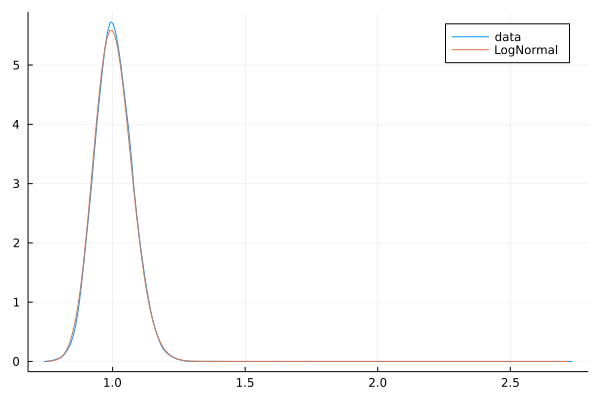

In [123]:
Nt = 20000000 #number of draws
d = Normal(0, p.psi)
innov = rand(d, Nt)
log_z = zeros(Nt)
z = zeros(Nt)
log_z[1] = 1.0
for t=2:Nt
    log_z[t] = p.rho*log_z[t-1] + innov[t]
end
z = exp.(log_z)
d_log_normal = LogNormal(0.0, p.sigma)

density(z, label="data")
plot!(minimum(z):0.01:maximum(z), x -> pdf(d_log_normal, x), label="LogNormal")

Most of the time, $z$ is going to be between the 5th and the 95th percentile of $Lognormal(0, \sigma)$. Hence, we define the grid for $z$ to be $[P5, P95]$.

In [124]:
P5 = quantile(d_log_normal, 0.05)
P95 = quantile(d_log_normal, 0.95)
println("P5: $(P5); P95: $(P95)")

P5: 0.8891200789438004; P95: 1.1247074761689282


In [125]:
#Sampling for training
n_samples_xy = 10; #number of draws for the x and y dimensions
n_samples_z = 10; #number of draws for the z dimension
lower_bound = [0.0, 0.0, P5]
upper_bound = [1.0, 1.0, P95]

x_grid = collect(range(lower_bound[1], upper_bound[1], length=n_samples_xy))
y_grid = collect(range(lower_bound[2], upper_bound[2], length=n_samples_xy))
z_grid = collect(range(lower_bound[3], upper_bound[3], length=n_samples_z))

nodes_xyz = (x_grid, y_grid, z_grid, ); #for package Interpolations

#### Value function iteration 

The following block of code uses the VFI algorithm and displays the final results. The value function $S(x,y,z)$ is a non-linear transformation of the value of net output of the job $s(x,y,z)$.

Iter 100 Diff : 0.18062930117157094
Iter 200 Diff : 0.04545706889411605
Iter 300 Diff : 0.011441422819899572
Iter 400 Diff : 0.002880196260427681
Iter 500 Diff : 0.0007251468880724588
Iter 600 Diff : 0.00018259564639322434
Iter 700 Diff : 4.598479092265961e-5
Iter 800 Diff : 1.1582340917470901e-5
Iter 900 Diff : 2.9176678424391866e-6
Iter 1000 Diff : 7.350753179480307e-7
Iter 1100 Diff : 1.8521812705785123e-7
Iter 1200 Diff : 4.6675602050072484e-8
Iter 1300 Diff : 1.1763880536364013e-8
Iter 1312 Convergence reached
 43.861711 seconds (266.61 M allocations: 12.326 GiB, 3.34% gc time, 0.15% compilation time)


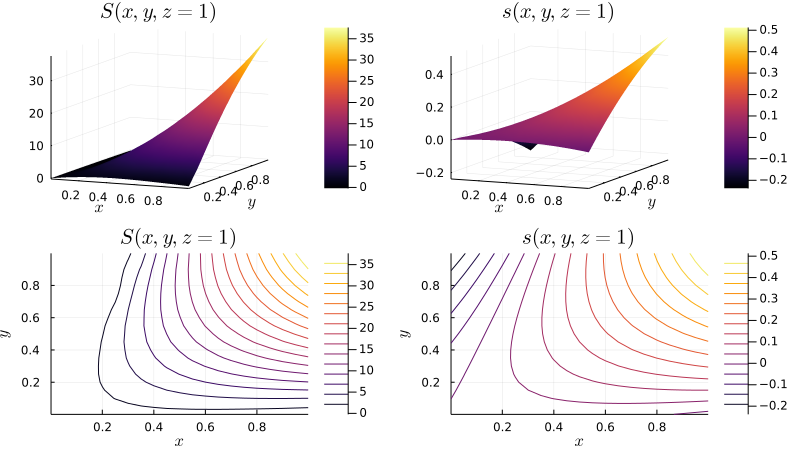

In [126]:
V_old = zeros(n_samples_xy, n_samples_xy, n_samples_z)
V_new = zeros(n_samples_xy, n_samples_xy, n_samples_z)

# Initial guess
for (zIndex, zValue) in enumerate(z_grid)
    for (yIndex, yValue) in enumerate(y_grid)
        for (xIndex, xValue) in enumerate(x_grid)
            V_old[xIndex, yIndex, zIndex] = p.s_xyz(xValue, yValue, zValue) + ((1.0 - p.delta)/(1.0 + p.r))*max(0.0, p.s_xyz(xValue, yValue, zValue))
        end
    end
end

itp = interpolate(nodes_xyz, V_old, Gridded(Linear()))
etp = extrapolate(itp, Line())
V_old_interpolated = (x) -> etp(x[1], x[2], x[3])

max_iter = 5000
tol = 10^-8

@time begin
    # Initialize
    for i = 1:max_iter

        for (zIndex, zValue) in enumerate(z_grid)
            for (yIndex, yValue) in enumerate(y_grid)
                for (xIndex, xValue) in enumerate(x_grid)
                    V_new[xIndex, yIndex, zIndex] = p.s_xyz(xValue, yValue, zValue) + ((1.0 - p.delta)/(1.0 + p.r)).*sum(p.weigths_E.*[max.(0.0, V_old_interpolated([xValue; yValue; (zValue.^p.rho).*exp.(innovation)])) for innovation in p.nodes_E])
                end
            end
        end

        # DISTANCE
        diff= maximum(abs.(V_new .- V_old))
        if mod(i, 100) == 0
            println("Iter $(i) Diff : $(diff)")
        end

        if diff < tol
            println("Iter $(i) Convergence reached")
            break
        end

        #UPDATE
        V_old = copy(V_new)
        itp = interpolate(nodes_xyz, V_old, Gridded(Linear()))
        etp = extrapolate(itp, Line())
        V_old_interpolated = (x) -> etp(x[1], x[2], x[3])

    end
end

# Plot output for trained neural network
p1 = plot(p.x_grid, p.y_grid, (x, y) -> V_old_interpolated([x; y; 1.0])[1], label = "f(x)", st=:surface)
title!(L"S(x,y,z=1)")
xlabel!(L"x")
ylabel!(L"y")

# Initialization function
p2 = plot(p.x_grid, p.y_grid, (x, y) -> p.s_xyz(x, y, 1.0), label = "f(x)", st=:surface)
title!(L"s(x,y,z=1)")
xlabel!(L"x")
ylabel!(L"y")

p3 = plot(p.x_grid, p.y_grid, (x, y) -> V_old_interpolated([x; y; 1.0])[1], label = "f(x)", st=:contour)
title!(L"S(x,y,z=1)")
xlabel!(L"x")
ylabel!(L"y")

p4 = plot(p.x_grid, p.y_grid, (x, y) -> p.s_xyz(x, y, 1.0), label = "f(x)", st=:contour)
title!(L"s(x,y,z=1)")
xlabel!(L"x")
ylabel!(L"y")

ratio = 9/16
width = 800
pp = plot(p1, p2, p3, p4, size = (width, width*ratio))

### II.C. Bellman - ANN

When doing value function iteration, one does not have to vectorize the code. However, I have learned the hard-way that it matters quite a lot when switching to the ANN approach, especially if you aim to use a GPU. So let's tackle this problem right now.

The trick is to realize that the expectation operator is just a large weighted average, which can be represented by a matrix multiplication when grid points are chosen carefully. 

Let's consider all the value of $S(x,y,z)$ from the grid, arranged in a large row vector of dimension $(1; n_x \times n_y \times n_z)$ : $$ \begin{pmatrix}
S(x_1,y_1, z_1) & S(x_2,y_1, z_1) & ... & S(x_{nx},y_{ny}, z_{nz})
\end{pmatrix}$$

Using this convention, one can verify that the initial Bellman equation can be written as:

$$ \begin{pmatrix}
S(x_1,y_1, z_1) & S(x_2,y_1, z_1) & ... & S(x_{nx},y_{ny}, z_{nz})
\end{pmatrix} = \begin{pmatrix}s(x_1,y_1, z_1) & s(x_2,y_1, z_1) & ... & s(x_{nx},y_{ny}, z_{nz}) \end{pmatrix} + \frac{1 - \delta}{1 + r} \begin{pmatrix}
S(x_1,y_1, z_1'|z_1) & S(x_1,y_1, z_2'|z_1) & ... & S(x_1,y_1, z_{nz'}|z_1) & S(x_2,y_1, z_{1'}|z_1) & ... & S(x_{nx},y_{ny}, z_{nz'}|z_{nz})
\end{pmatrix} \times W
$$

where $W$ is large matrix of dimension $(n_x \times n_y \times n_z \times n_{z'}; n_x \times n_y \times n_z)$ containing the weigths to approximate the expectation operator:

$$ W \equiv \begin{pmatrix} w1 & w2 & ... & w_{nz'} & 0 & ... & 0\\ 
                            0 & 0 & ... & 0 & w1 & w2 & ... & w_{nz'} & 0 & ... 0\\
                            0 & 0 & ... & 0 & 0 & 0 & ... & 0 & w1 & w2 & ... & w_{nz'}
                            \end{pmatrix} ^T $$
                            
For this vectorized approach to work, we need to define two grids: 

* one grid for the 
$ \begin{pmatrix}
S(x_1,y_1, z_1) & S(x_2,y_1, z_1) & ... & S(x_{nx},y_{ny}, z_{nz})
\end{pmatrix} $

* one grid for the expectation part $\begin{pmatrix}
S(x_1,y_1, z_1'|z_1) & S(x_1,y_1, z_2'|z_1) & ... & S(x_1,y_1, z_{nz'}|z_1) & S(x_2,y_1, z_{1'}|z_1) & ... & S(x_{nx},y_{ny}, z_{nz'}|z_{nz})
\end{pmatrix}$

I also define some grid points that are not used for the gradient descent phase (the "test set"). These points allow us to verify that we are not overfitting the training sample.

In [127]:
nb_dim = 3

#-------------------------------------------------------------
# Train set
#-------------------------------------------------------------
# Grid for the LHS
# Grid (1, nx * ny * nz )
grid_1 = zeros(nb_dim, n_samples_xy*n_samples_xy*n_samples_z);

index = 1
for (xValue, yValue, zValue) in product(x_grid, y_grid, z_grid)
    grid_1[1, index] = xValue
    grid_1[2, index] = yValue
    grid_1[3, index] = zValue
    index+=1
end

# Grid for the RHS (calculate expectations)
# Grid (1, nx * ny * nz * nz')
grid_2 = zeros(nb_dim, n_samples_xy*n_samples_xy*n_samples_z*p.nb_nodes);

# Populate grid_2
index = 1
for (xValue, yValue, zValue) in product(x_grid, y_grid, z_grid)
    for (innovation_index, innovation) in enumerate(p.nodes_E)
        grid_2[1, index] = xValue
        grid_2[2, index] = yValue
        grid_2[3, index] = (zValue.^p.rho).*exp.(innovation)
        index+=1
    end
end

#-------------------------------------------------------------
# Test set
#-------------------------------------------------------------
# Sampling for test
n_samples_test = 1000
grid_test_1 = zeros(nb_dim, n_samples_test);

index = 1
for (xValue, yValue, zValue) in Surrogates.sample(n_samples_test, lower_bound, upper_bound, SobolSample())
    grid_test_1[1, index] = xValue
    grid_test_1[2, index] = yValue
    grid_test_1[3, index] = zValue
    index+=1
end

grid_test_2 = zeros(nb_dim, n_samples_xy*n_samples_xy*n_samples_z*p.nb_nodes);

# Populate grid_test_2
index = 1
for (xValue, yValue, zValue) in zip(grid_test_1[1,:], grid_test_1[2,:], grid_test_1[3,:])
    for (innovation_index, innovation) in enumerate(p.nodes_E)
        grid_test_2[1, index] = xValue
        grid_test_2[2, index] = yValue
        grid_test_2[3, index] = (zValue.^p.rho).*exp.(innovation)
        index+=1
    end
end

# To calculate the expectation
W = sparse(kronecker(Matrix(I, n_samples_xy*n_samples_xy*n_samples_z, n_samples_xy*n_samples_xy*n_samples_z), p.weigths_E));

In [128]:
# Define the neural network layers
# Specify our model
dim_input = 3
dim_ouptut = 1

Q1 = 300; 
Q2 = 100; 
Q3 = 10; 

activation_f = relu;

model = Chain(Dense(dim_input,Q1,activation_f),
            Dense(Q1,Q2,activation_f),
            Dense(Q2,Q3,activation_f),
            Dense(Q3,dim_ouptut,identity));

Check one pass of the gradient:

In [129]:
ps = Flux.params(model)
y = zeros(1, size(grid_1, 2))
s_xyz_r = transpose(p.s_xyz_r(grid_1)) #precalculate net output on grid

@time begin
    gs = gradient(() -> Flux.Losses.mse(model(grid_1) - s_xyz_r + ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, model(grid_2))*W, y), ps)
end

  1.095857 seconds (203.34 k allocations: 261.396 MiB, 13.23% gc time, 35.78% compilation time)


Grads(...)

#### Initializing the model

We can start with random coefficients and try to solve for the function S(.) directly. 
However, it is better to initialize the coefficients of the ANN to match a not too far-fetched guess:

In [130]:
lr = 0.001 # learning rate when batchsize = 1000
opt = ADAM(lr)

epochs_training = 100 # Define the number of epochs
trainingLosses = zeros(epochs_training); # Keep track of the training progress
testLosses = zeros(epochs_training); # Test on data not used in the training

ps = Flux.params(model) #initialize weigths
p_bar = Progress(epochs_training; desc = "Training in progress"); # Creates a progress bar
showProgress = true

y = zeros(1, size(grid_1, 2))
s_xyz_r = transpose(p.s_xyz_r(grid_1)) #precalculate net output on grid
s_xyz_r_test = transpose(p.s_xyz_r(grid_test_1)) #precalculate net output on test grid

# Training loop
@time for ii in 1:epochs_training
    
    gs = gradient(() -> Flux.Losses.mse(model(grid_1) - s_xyz_r - ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, s_xyz_r), y), ps)# compute gradient
    Flux.Optimise.update!(opt, ps, gs) # update parameters

    
    if showProgress
        trainingLosses[ii] = Flux.Losses.mse(model(grid_1) - s_xyz_r - ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, s_xyz_r), y)
        testLosses[ii] = Flux.Losses.mse(model(grid_test_1) - s_xyz_r_test - ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, s_xyz_r_test), y)
        next!(p_bar; showvalues = [(:epochs, ii), (:logloss, log.(trainingLosses[ii])), (:loglosstest, log.(testLosses[ii]))], valuecolor = :grey)
    end

end



┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/julien/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Training in progress100%|███████████████████████████████| Time: 0:00:07
  epochs:       100
  logloss:      -6.198231731362997
  loglosstest:  -6.480455135391009


  7.398687 seconds (285.46 k allocations: 2.889 GiB, 5.29% gc time, 5.06% compilation time)


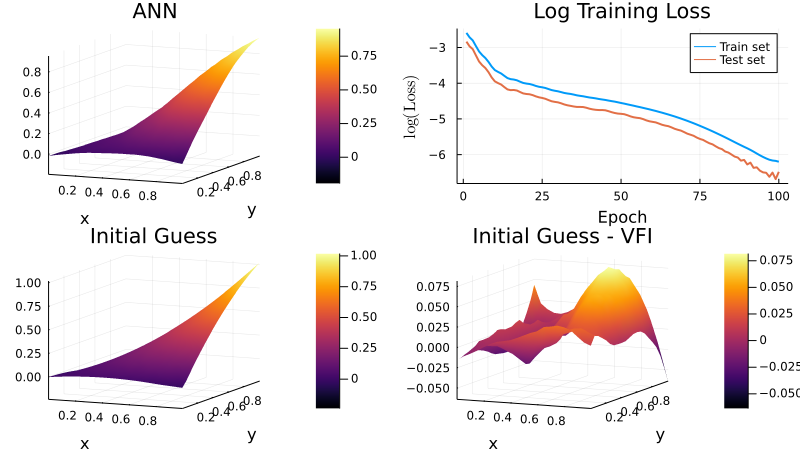

In [131]:
init_f = (x,y,z) -> p.s_xyz(x,y,z) .+ ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, p.s_xyz(x,y,z))

gr()
# Plot output for trained neural network
p1 = plot(p.x_grid, p.y_grid, (x, y) -> model([x; y; 1.0])[1], label = "f(x)", st=:surface)
title!("ANN")
xlabel!("x")
ylabel!("y")

# Plot training loss
p2 = plot(1:epochs_training, log.(trainingLosses), label = "Train set", linewidth = 2)
plot!(1:epochs_training, log.(testLosses), label = "Test set", linewidth = 2)
title!("Log Training Loss")
xlabel!("Epoch")
ylabel!(L"\log(\textrm{Loss})")

# Plot training loss
# Plot output for trained neural network
p3 = plot(p.x_grid, p.y_grid, (x, y) -> init_f(x, y, 1.0), label = "f(x)", st=:surface)
title!("Initial Guess")
xlabel!("x")
ylabel!("y")

# Plot training loss
# Plot output for trained neural network
p4 = plot(p.x_grid, p.y_grid, (x, y) -> model([x; y; 1.0])[1] - init_f(x, y, 1.0), label = "f(x)", st=:surface)
title!("Initial Guess - VFI")
xlabel!("x")
ylabel!("y")


ratio = 9/16
width = 800
pp = plot(p1, p2, p3, p4, size = (width, width*ratio))

#### Solving the real problem

Now that the coefficients are initialized, let's tackle the real problem:

In [132]:
lr = 0.001 # learning rate
opt = ADAM(lr)

epochs_training = 1000 # Define the number of epochs
trainingLosses = zeros(epochs_training); # Keep track of the training progress
testLosses = zeros(epochs_training); # Test on data not used in the training

ps = Flux.params(model) #initialize weigths
p_bar = Progress(epochs_training; desc = "Training in progress"); # Creates a progress bar
showProgress = true

y = zeros(1, size(grid_1, 2))
s_xyz_r = transpose(p.s_xyz_r(grid_1)) #precalculate net output on grid
s_xyz_r_test = transpose(p.s_xyz_r(grid_test_1)) #precalculate net output on test grid

# Training loop
@time for ii in 1:epochs_training
    
    gs = gradient(() -> Flux.Losses.mse(model(grid_1) - s_xyz_r - ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, model(grid_2))*W, y), ps)# compute gradient
    Flux.Optimise.update!(opt, ps, gs) # update parameters
    
    if showProgress
        trainingLosses[ii] = Flux.Losses.mse(model(grid_1) - s_xyz_r - ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, model(grid_2))*W, y)
        testLosses[ii] = Flux.Losses.mse(model(grid_test_1) - s_xyz_r_test - ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, model(grid_test_2))*W, y)
        next!(p_bar; showvalues = [(:epochs, ii), (:logloss, log.(trainingLosses[ii])), (:loglosstest, log.(testLosses[ii]))], valuecolor = :grey)
    end

end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/julien/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Training in progress100%|███████████████████████████████| Time: 0:08:47
  epochs:       1000
  logloss:      -7.247630080617367
  loglosstest:  -7.022159208051979


527.918020 seconds (2.05 M allocations: 380.917 GiB, 0.84% gc time, 0.08% compilation time)


Training on the full problem is succesfull, as illustrated on the graphs below. It is hard to see meaningfull differences between
VFI and the ANN. 

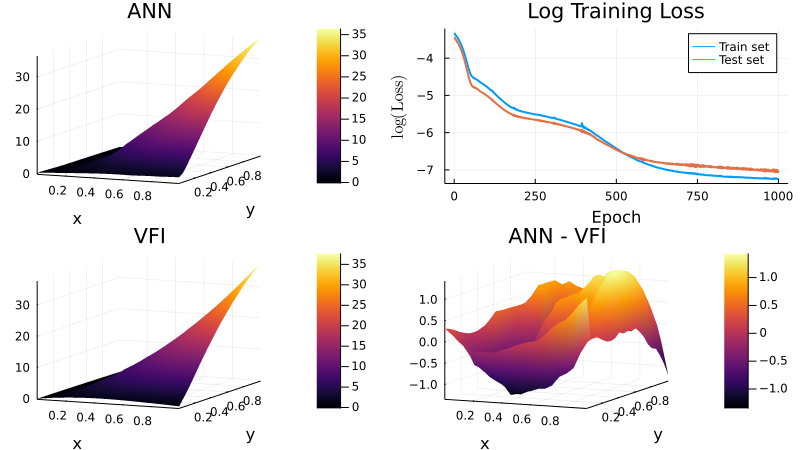

In [133]:
gr()
# Plot output for trained neural network
p1 = plot(p.x_grid, p.y_grid, (x, y) -> model([x; y; 1.0])[1], label = "f(x)", st=:surface)
title!("ANN")
xlabel!("x")
ylabel!("y")

# Plot training loss
p2 = plot(1:epochs_training, log.(trainingLosses), label = "Train set", linewidth = 2)
plot!(1:epochs_training, log.(testLosses), label = "Test set", linewidth = 2)
title!("Log Training Loss")
xlabel!("Epoch")
ylabel!(L"\log(\textrm{Loss})")

# Plot training loss
# Plot output for trained neural network
p3 = plot(p.x_grid, p.y_grid, (x, y) -> V_old_interpolated([x; y; 1.0])[1], label = "f(x)", st=:surface)
title!("VFI")
xlabel!("x")
ylabel!("y")

# Plot training loss
# Plot output for trained neural network
p4 = plot(p.x_grid, p.y_grid, (x, y) -> model([x; y; 1.0])[1] - V_old_interpolated([x; y; 1.0])[1], label = "f(x)", st=:surface)
title!("ANN - VFI")
xlabel!("x")
ylabel!("y")


ratio = 9/16
width = 800
pp = plot(p1, p2, p3, p4, size = (width, width*ratio))

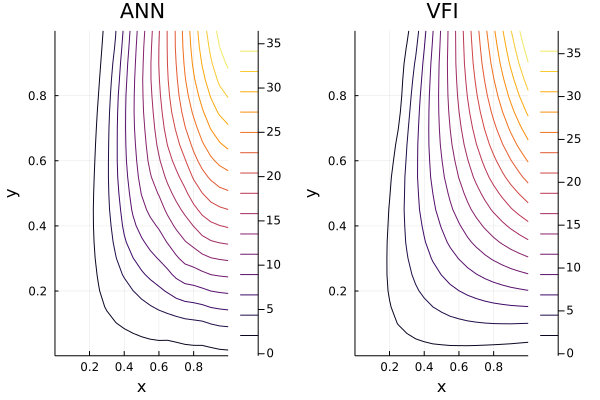

In [134]:
zValue = 1.0

p1 = plot(p.x_grid, p.y_grid, (x, y) -> model([x; y; zValue])[1], label = "f(x)", st=:contour)
title!("ANN")
xlabel!("x")
ylabel!("y")

p2 = plot(p.x_grid, p.y_grid, (x, y) -> V_old_interpolated([x,y, zValue]), label = "f(x)", st=:contour)
title!("VFI")
xlabel!("x")
ylabel!("y")

plot(p1, p2)

#### Accuracy tests

Accuracy of VFI versus ANN approaches can be assessed by looking at off-grid points. 
In the present setting, VFI outperforms the ANN approach. However, I conjecture that in a high-dimensional setting the opposite would be true (in a high-dimensional setting, VFI probably would not be possible in the first place). Also, one could increase the number of epochs and get better results.

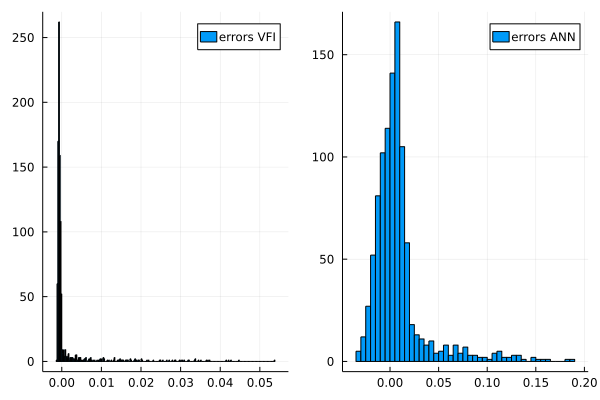

In [135]:
#VFI
#LHS
LHS = zeros(size(grid_test_1, 2))
index = 1
for (xValue, yValue, zValue) in zip(grid_test_1[1, :], grid_test_1[2, :], grid_test_1[3,:])
    LHS[index] = V_old_interpolated([xValue; yValue; zValue])
    index+=1
end


#RHS
RHS = zeros(size(grid_test_1, 2))
index = 1
for (xValue, yValue, zValue) in zip(grid_test_1[1, :], grid_test_1[2, :], grid_test_1[3,:])
    RHS[index] = p.s_xyz(xValue, yValue, zValue) + ((1.0 - p.delta)/(1.0 + p.r)).*sum(p.weigths_E.*[max.(0.0, V_old_interpolated([xValue; yValue; (zValue.^p.rho).*exp.(innovation)])) for innovation in p.nodes_E])
    index+=1
end

#ANN
error_ANN = model(grid_test_1) - transpose(p.s_xyz_r(grid_test_1)) - ((1.0 - p.delta)/(1.0 + p.r)).*max.(0.0, model(grid_test_2)*W)
error_ANN = transpose(error_ANN)
p1 = histogram(LHS - RHS, label="errors VFI")
p2 = histogram(error_ANN, label="errors ANN")
plot(p1, p2)

In [136]:
df = DataFrame(Method = ["VFI", "ANN"], 
                MSE = [mean(LHS .- RHS).^2, mean(error_ANN).^2],
                MDSE = [median(LHS .- RHS).^2, median(error_ANN).^2],
                MAXSE = [maximum(LHS .- RHS).^2, maximum(error_ANN).^2],
                MINSE = [minimum(LHS .- RHS).^2, minimum(error_ANN).^2])

df

,Method,MSE,MDSE,MAXSE,MINSE
,String,Float64,Float64,Float64,Float64
1,VFI,1.99895e-6,3.47266e-7,0.00288945,1.5217e-6
2,ANN,7.47681e-5,1.37991e-5,0.035538,0.00108539


## Conclusion

In this blog post, I showed how ANN can be used to find unknown functions satisfying a Bellman equation.

The code presented here is more a **proof-of-concept than a production-ready release**. A first obvious improvement is to train the ANN on a **GPU instead of a CPU**. Using the free version of [Google Colab](https://colab.research.google.com/), I am getting an almost 10x time improvement. A second improvement would be to use more diverse set of points for the ANN. While VFI requires a fixed grid to make sense, the ANN is a grid-less method. The training phase would benefit from more mixing in the input points.

As a final remark, I chose on purpose a problem which is a bit much simpler than the full general problem, in which one must also find the policy function that comes with the unknown value function. I am wondering if some of the insights described in the [Alpha Go paper](https://www.nature.com/articles/nature16961) could apply in the present setting.

## Appendix

In [137]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
